# Averaged XGBoost and LightGBM model
---

In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import stats, norm, skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.special import boxcox1p
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline
np.random.seed(2)

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
train = train.drop('Id', axis=1)
train.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Filling NaNs

## TODO: spend some more time on these columns

### 1: strings

In [4]:
cols_with_none_as_nan = [
    "PoolQC", 
    "MiscFeature", 
    "Alley", 
    "Fence", 
    "FireplaceQu", 
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'Electrical', 
    'BsmtFinType1', 
    'BsmtFinType2', 
    "MasVnrType",
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType']


o = train.dtypes[train.dtypes==object].index
print(o)

# fill missing text fields with a default string
object_columns = train[o]
test_object_columns = test[o]

# for these colunms the string 'None' will be inserted in place of nan
for col in cols_with_none_as_nan:
    object_columns.loc[:, col] = object_columns.loc[:, col].fillna('None')
    test_object_columns.loc[:, col] = test_object_columns.loc[:, col].fillna('None')

remaining_fix = object_columns.isnull().sum()
print('Fixes remaining on train set\n', remaining_fix[remaining_fix>0])

remaining_fix = test_object_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


# From string to ordinal
Many categorical features contain **ordinal** values; the chart that follows shows that in most cases, the category influences the SalePrice label.

In [5]:
# Base scale, taken from 'OverallCond' feature
#   10   Very Excellent
#   9    Excellent
#   8    Very Good
#   7    Good
#   6    Above Average   
#   5    Average
#   4    Below Average   
#   3    Fair
#   2    Poor
#   1    Very Poor

#   Ex   Excellent (100+ inches) 
#   Gd   Good (90-99 inches)
#   TA   Typical (80-89 inches)
#   Fa   Fair (70-79 inches)
#   Po   Poor (&lt;70 inches
#   NA   No Basement

quals_mapping = {
    "Ex": 9,
    "Gd": 7,
    "Av": 5,
    "TA": 5,
    "Fa": 3,
    "Po": 2,
    "NA": 0,
    "None": 0
}
quals_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', ]

for c in object_columns.columns:
    if c in quals_columns:
        vals = np.unique(object_columns[c])
        for v in quals_mapping:
            object_columns.loc[:,c] = object_columns[c].replace(to_replace=v, value=quals_mapping[v])
            test_object_columns.loc[:,c] = test_object_columns[c].replace(to_replace=v, value=quals_mapping[v])


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In order to make the category influence the predicted price with the correct amount, I'm going to exchange each category with the mean saleprice value for all the entries with that category.

### 2: numerics

In [6]:
numeric_columns = train.select_dtypes(include=[int, float])

remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

test_numeric_columns = test.select_dtypes(include=[int, float])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
Fixes remaining on test set
 LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [7]:
cols_with_zero_as_nan = ['MasVnrArea', 
                         'GarageYrBlt',
                         'BsmtFinSF1',
                         'BsmtFinSF2',
                         'BsmtUnfSF',
                         'TotalBsmtSF',
                         'BsmtFullBath',
                         'BsmtHalfBath',
                         'GarageCars',
                         'GarageArea',
                        ]
cols_with_mean_as_nan = ['LotFrontage']

# for these colunms the mean will be inserted in place of nan
for col in cols_with_mean_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(numeric_columns[col].mean())
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(test_numeric_columns[col].mean())

# for these colunms a zero will be inserted in place of nan
for col in cols_with_zero_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(0)
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(0)


remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


## Removing outliers in OverallQual and SalePrice

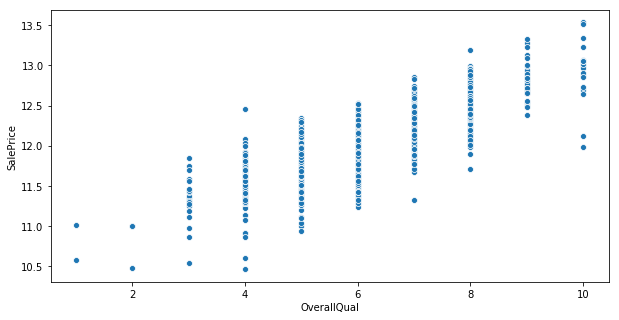

In [8]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns.loc[:,'OverallQual'], y=np.log1p(train['SalePrice']))
plt.show()


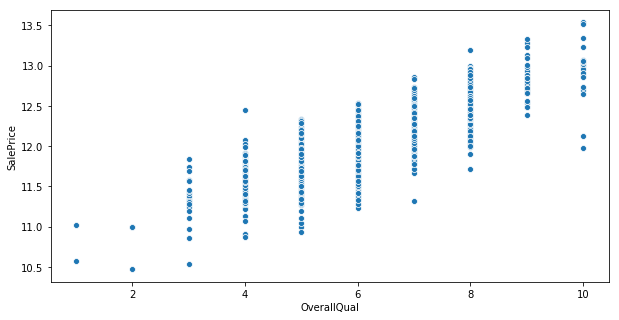

In [9]:
for d in numeric_columns[numeric_columns['OverallQual'] == 4].index:
    if np.log1p(numeric_columns.loc[d,'SalePrice']) < 10.8:
        numeric_columns = numeric_columns.drop(d, axis=0)
        object_columns = object_columns.drop(d, axis=0)

plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns.loc[:,'OverallQual'], y=np.log1p(train['SalePrice']))
plt.show()


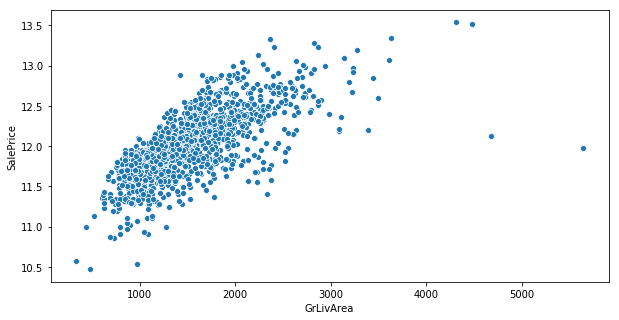

In [10]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns['GrLivArea'], y=np.log1p(train['SalePrice']))
plt.show()


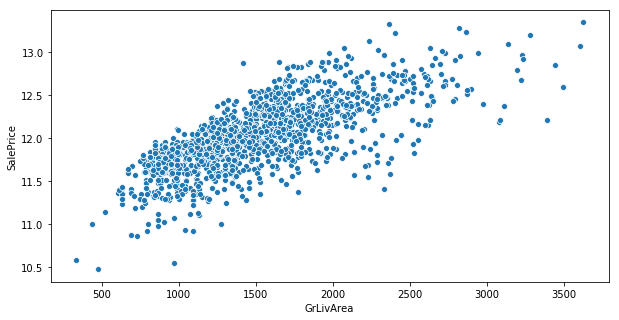

In [11]:
for d in numeric_columns[numeric_columns['GrLivArea'] > 4000].index:
    numeric_columns = numeric_columns.drop(d, axis=0)
    object_columns = object_columns.drop(d, axis=0)

plt.figure(figsize=(10,5))
sns.scatterplot(x=numeric_columns['GrLivArea'], y=np.log1p(train['SalePrice']))
plt.show()


# Enconding string columns with LabelEncoder

In [12]:

strings = np.array([])
for c in object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    if c not in quals_columns:
        strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings), 'distinct labels generated')

labeler = LabelEncoder()
labeler.fit(strings)

for c in object_columns.columns:
    if c not in quals_columns:
        object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
        test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

422 distinct labels generated


/home/daneel/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0       129     123    111       136           86         12         84   
1       129     123    111       136           86         12         52   
2       129     123    111        80           86         12         84   
3       129     123    111        80           86         12         46   
4       129     123    111        80           86         12         52   

   LandSlope  Neighborhood  Condition1      ...        GarageType  \
0         75            40         112      ...                17   
1         75           158          56      ...                17   
2         75            40         112      ...                17   
3         75            47         112      ...                49   
4         75           109         112      ...                17   

   GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0           127           5           5         168       0    111   
1           127           5           5         168       0    111   
2           127           5           5         168       0    111   
3           157           5           5         168       0    111   
4           127           5           5         168       0    111   

   MiscFeature  SaleType  SaleCondition  
0          111       160            113  
1          111       160            113  
2          111       160            113  
3          111       160             10  
4          111       160            113  

[5 rows x 43 columns]

# Assembling the datasets

In [13]:
# final train dataset
train_ds = object_columns.join(numeric_columns)
train_ds["SalePrice"] = np.log1p(train_ds["SalePrice"])

# test dataset
test_ds = test_object_columns.join(test_numeric_columns)



### Discarding less correlated features

In [14]:
# keeping only the most promising features
corrmat = train_ds.corr()['SalePrice']
best_columns = corrmat[abs(corrmat) > 0.01].index

print('Keeping only ', len(best_columns), 'features out of ', len(train_ds.columns))

train_ds = train_ds[best_columns]
test_ds = test_ds[best_columns.drop('SalePrice')]


Keeping only  79 features out of  80


In [15]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)
print('Test set shape', test_ds.shape)


Training set features shape (1454, 78)
Training set labels shape (1454, 1)
Test set shape (1459, 78)


#### RobustScaler

In [16]:
print(test_ds.dtypes[test_ds.dtypes==object])

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train))
X_test = pd.DataFrame(transformer.transform(X_test))


Series([], dtype: object)


In [17]:
print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)


Training set features shape (1454, 78)
Training set labels shape (1454, 1)


## Training functions

In [18]:
def train_model(depth, learning_rate, n_estimators, model_type='xgb'):
    if model_type == 'xgb':
        print('XGBRegressor')
        model = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=depth, 
                                 n_estimators=n_estimators,
                                 silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lgb':
        print('LGBMRegressor')
        model = lgb.LGBMRegressor(learning_rate=learning_rate, max_depth=depth, 
                                 n_estimators=n_estimators,
                                 silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lasso':
        print('Lasso')
        model = Lasso(alpha =0.0006)
        
    if model_type == 'elastic':
        print('ElasticNet')
        model = ElasticNet(alpha=0.0012, l1_ratio=.5)
        
    score = rmsle_cv(model)
    print(model_type, " score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
    return score

#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.flatten(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# Training: Lasso


In [19]:
depth = 0
learning_rate = 0
n_estimators = 0

score = train_model(depth, learning_rate/100, n_estimators, model_type='lasso')


Lasso
lasso  score: depth=0 lr=0.00 est=0 -> mean:0.11709 std:0.0109


In [20]:
# train with the best parameters
model_lasso = Lasso(alpha=0.0006)

score = rmsle_cv(model_lasso)
print("model_lr score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_lasso.fit(X_train, y_train)
y_pred = model_lasso.predict(X_train)
print('RMSLE LR = ', rmsle(y_train, y_pred))


model_lr score: depth=0 lr=0.00 est=0 -> mean:0.11709 std:0.0109
RMSLE LR =  0.10960762513312203


* model_lr score: depth=0 lr=0.00 est=0 -> mean:0.11706 std:0.0111
* RMSLE LR =  0.10950991422359595


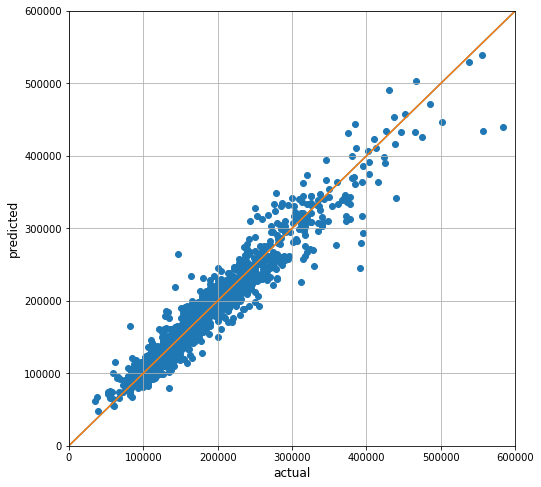

In [21]:
plt.figure(figsize=(8, 8))
y_pred = model_lasso.predict(X_train)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: ElasticNet


In [22]:
score = train_model(depth, learning_rate/100, n_estimators, model_type='elastic')


ElasticNet
elastic  score: depth=0 lr=0.00 est=0 -> mean:0.11706 std:0.0109


In [23]:
# train with the best parameters
model_elastic = ElasticNet(alpha=0.0005, l1_ratio=.5)

score = rmsle_cv(model_elastic)
print("model_elastic score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_elastic.fit(X_train, y_train)
y_pred = model_elastic.predict(X_train)
print('RMSLE model_elastic = ', rmsle(y_train, y_pred))


model_elastic score: depth=0 lr=0.00 est=0 -> mean:0.11738 std:0.0109
RMSLE model_elastic =  0.10935541002607424


* model_elastic score: depth=0 lr=0.00 est=0 -> mean:0.11709 std:0.0111
* RMSLE model_elastic =  0.10947185086398303

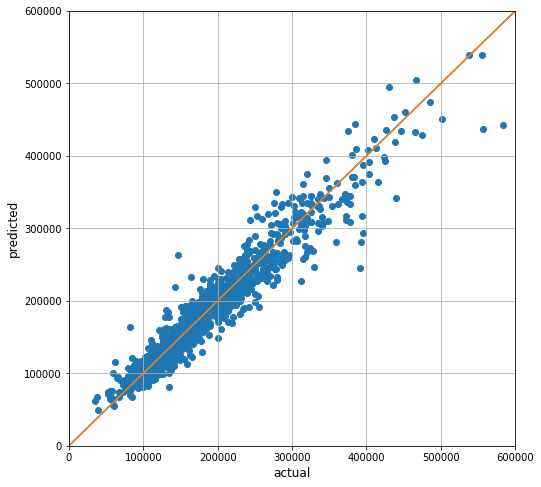

In [24]:
plt.figure(figsize=(8, 8))
y_pred = model_elastic.predict(X_train)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: XGBoost


In [25]:

result = []
for depth in range(3, 5):
    for learning_rate in range(2, 3, 1):
        for n_estimators in range(1200, 2000, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='xgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


XGBRegressor
xgb  score: depth=3 lr=0.02 est=1200 -> mean:0.11380 std:0.0157
XGBRegressor
xgb  score: depth=3 lr=0.02 est=1400 -> mean:0.11373 std:0.0159
XGBRegressor
xgb  score: depth=3 lr=0.02 est=1600 -> mean:0.11355 std:0.0161
XGBRegressor
xgb  score: depth=3 lr=0.02 est=1800 -> mean:0.11331 std:0.0163
XGBRegressor
xgb  score: depth=4 lr=0.02 est=1200 -> mean:0.11281 std:0.0159
XGBRegressor
xgb  score: depth=4 lr=0.02 est=1400 -> mean:0.11285 std:0.0160
XGBRegressor
xgb  score: depth=4 lr=0.02 est=1600 -> mean:0.11279 std:0.0161
XGBRegressor
xgb  score: depth=4 lr=0.02 est=1800 -> mean:0.11271 std:0.0162


In [26]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


depth  learning_rate  n_estimators  score_mean  score_std
count  8.000000           8.00      8.000000    8.000000   8.000000
mean   3.500000           0.02   1500.000000    0.113194   0.016021
std    0.534522           0.00    239.045722    0.000456   0.000191
min    3.000000           0.02   1200.000000    0.112711   0.015700
25%    3.000000           0.02   1350.000000    0.112807   0.015887
50%    3.500000           0.02   1500.000000    0.113078   0.016043
75%    4.000000           0.02   1650.000000    0.113596   0.016159
max    4.000000           0.02   1800.000000    0.113801   0.016261

In [27]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               4.000000
learning_rate       0.020000
n_estimators     1800.000000
score_mean          0.112711
score_std           0.016218
Name: 7, dtype: float64


```
Best params = 
 depth               3.000000
learning_rate       0.030000
n_estimators     1800.000000
score_mean          0.112694
score_std           0.016205
Name: 7, dtype: float64
```

In [28]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_xgb = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=depth, 
                         n_estimators=n_estimators,
                         silent=1,
                         random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
print('RMSLE XGB = ', rmsle(y_train, y_pred))


Xgboost score: depth=4 lr=0.02 est=1800 -> mean:0.11271 std:0.0162
RMSLE XGB =  0.034106915564138106


* Xgboost score: depth=3 lr=0.03 est=1800 -> mean:0.11269 std:0.0162
* RMSLE XGB =  0.04269559832775177


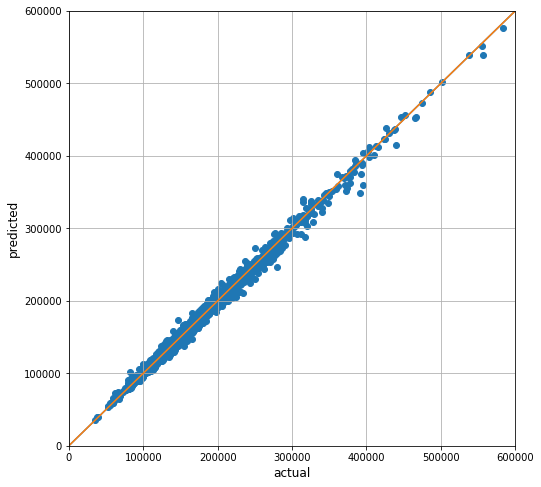

In [29]:
plt.figure(figsize=(8, 8))
y_pred = model_xgb.predict(X_train)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: lightgbm


In [30]:
result = []
for depth in range(3, 5):
    for learning_rate in range(2, 4, 1):
        for n_estimators in range(1200, 2000, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='lgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


LGBMRegressor
lgb  score: depth=3 lr=0.02 est=1200 -> mean:0.11474 std:0.0157
LGBMRegressor
lgb  score: depth=3 lr=0.02 est=1400 -> mean:0.11474 std:0.0157
LGBMRegressor
lgb  score: depth=3 lr=0.02 est=1600 -> mean:0.11482 std:0.0158
LGBMRegressor
lgb  score: depth=3 lr=0.02 est=1800 -> mean:0.11487 std:0.0157
LGBMRegressor
lgb  score: depth=3 lr=0.03 est=1200 -> mean:0.11496 std:0.0158
LGBMRegressor
lgb  score: depth=3 lr=0.03 est=1400 -> mean:0.11527 std:0.0157
LGBMRegressor
lgb  score: depth=3 lr=0.03 est=1600 -> mean:0.11555 std:0.0156
LGBMRegressor
lgb  score: depth=3 lr=0.03 est=1800 -> mean:0.11590 std:0.0156
LGBMRegressor
lgb  score: depth=4 lr=0.02 est=1200 -> mean:0.11632 std:0.0154
LGBMRegressor
lgb  score: depth=4 lr=0.02 est=1400 -> mean:0.11648 std:0.0153
LGBMRegressor
lgb  score: depth=4 lr=0.02 est=1600 -> mean:0.11667 std:0.0153
LGBMRegressor
lgb  score: depth=4 lr=0.02 est=1800 -> mean:0.11686 std:0.0152
LGBMRegressor
lgb  score: depth=4 lr=0.03 est=1200 -> mean:0.117

In [31]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


depth  learning_rate  n_estimators  score_mean  score_std
count  16.000000      16.000000     16.000000   16.000000  16.000000
mean    3.500000       0.025000   1500.000000    0.116206   0.015476
std     0.516398       0.005164    230.940108    0.001310   0.000223
min     3.000000       0.020000   1200.000000    0.114740   0.015177
25%     3.000000       0.020000   1350.000000    0.114936   0.015282
50%     3.500000       0.025000   1500.000000    0.116110   0.015459
75%     4.000000       0.030000   1650.000000    0.117015   0.015700
max     4.000000       0.030000   1800.000000    0.118617   0.015758

In [32]:
best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])


Best params = 
 depth               3.000000
learning_rate       0.020000
n_estimators     1200.000000
score_mean          0.114740
score_std           0.015709
Name: 0, dtype: float64


```
Best params = 
 depth               3.000000
learning_rate       0.030000
n_estimators     1200.000000
score_mean          0.114307
score_std           0.015887
Name: 4, dtype: float64
```

In [33]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_lgb = lgb.LGBMRegressor(learning_rate=learning_rate, max_depth=depth, 
                         n_estimators=n_estimators,
                         silent=1,
                         random_state =7, nthread = -1)


score = rmsle_cv(model_lgb)
print("lgb score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_lgb.fit(X_train, y_train.flatten())
y_pred = model_lgb.predict(X_train)

print('RMSLE LGB = ', rmsle(y_train, y_pred))


lgb score: depth=3 lr=0.02 est=1200 -> mean:0.11474 std:0.0157
RMSLE LGB =  0.0705571584067333


* lgb score: depth=3 lr=0.03 est=1200 -> mean:0.11431 std:0.0159
* RMSLE LGB =  0.0618131706199214


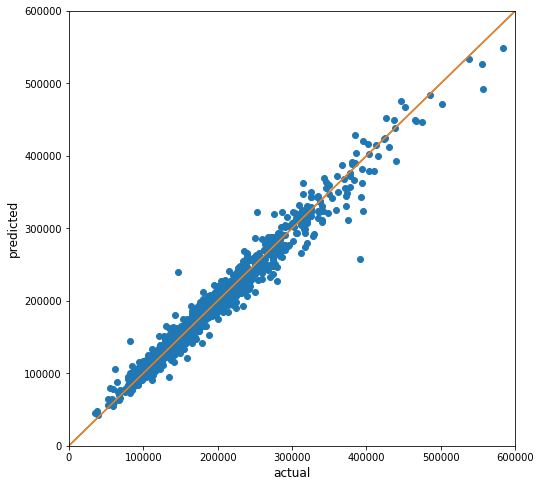

In [34]:

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Averaged model

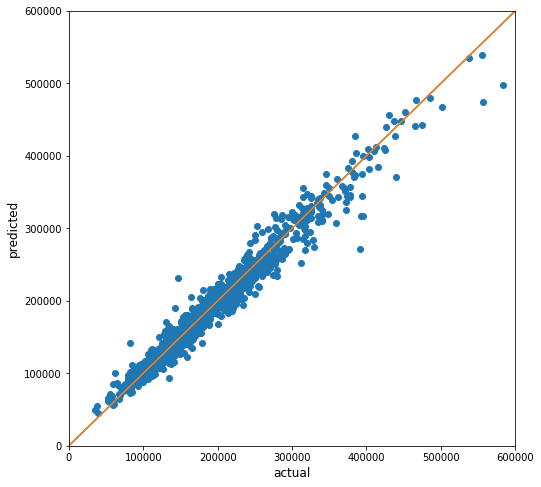

RMSLE LGB =  0.0760414756947219


In [35]:

avg_predicts = np.column_stack([
    model_xgb.predict(X_train),
    model_lgb.predict(X_train),
    model_lasso.predict(X_train),
    model_elastic.predict(X_train)
])

avg_predict = [np.mean(p) for p in avg_predicts]
y_pred = avg_predict

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 600_000)
plt.ylim(0, 600_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()

print('RMSLE LGB = ', rmsle(y_train, y_pred))



# Target: RMSLE LGB =  0.06539346038526068


In [36]:
# Submission

avg_predicts = np.column_stack([
    model_xgb.predict(X_test),
    model_lgb.predict(X_test),
    model_lasso.predict(X_test),
    model_elastic.predict(X_test)
])


avg_predict = [np.mean(p) for p in avg_predicts]

subm_predict = np.expm1(avg_predict)

dsubm_predict = pd.DataFrame(subm_predict)
dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]


SalePrice    Id
0  121098.060984  1461
1  160967.630162  1462
2  181311.732702  1463
3  192717.804710  1464
4  184310.628955  1465
5  172826.189488  1466
6  173402.124044  1467
7  164186.094968  1468
8  185591.691776  1469
9  122619.999770  1470

# Best score on kaggle: 0.12174